In [1]:
from ESN_model import *
import matplotlib.pyplot as plt

In [2]:
import torch
from torch_geometric.utils import to_dense_adj
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [3]:
from glob import glob
import pickle
import os.path as osp

In [4]:
import seaborn as sns

In [5]:
def get_data(file_path):
    with open(file_path, 'rb') as file:
        # Serialize and write the variable to the file
        data = pickle.load(file)
    return data

In [6]:
def load_single(file_path, display=False, percentile = 0):
    data = get_data(file_path)
    rmse = data['mean_rmse']
    
    if percentile:
        percentile_value = np.percentile(rmse,percentile)

        mask = data['mean_rmse'] < percentile_value
    else:
        mask = np.ones(len(rmse),dtype=bool)
    
    if display:
        sns.histplot(rmse, bins=30, kde=True )
        plt.axvline(percentile_value,color='orange')

        plt.show()
        
    reservoir = np.array(data['reservoir'])[mask] 
    w_in = np.array(data['w_in'])[mask]
    sparsity = np.array(data['sparsity'])[mask] 
    sparsity_mask = np.array(data['sparsity_mask'])[mask]
    feature_vectors = np.array(data['feature_vectors'])[mask] 
    
    return reservoir, w_in, sparsity, sparsity_mask, feature_vectors, rmse

In [7]:
def load_all(root_dir):
    paths = glob(osp.join(root_dir,'*.pickle'))
    all_data = get_data(paths[0])
    for idx, path in enumerate(paths[1:]):
        data = get_data(path)
        for key in all_data.keys():
            all_data[key] += data[key]
                
    return all_data
        

In [8]:
def select_the_best(data, percentile):
    """
        Returns mask for the ESNs with the best performance based on the passed percentile
    """
    if percentile != 0:
        threshold = np.percentile(data['mean_rmse'], percentile)
        mask = data['mean_rmse'] < threshold
    else:
        mask = np.ones(len(data['mean_rmse']),dtype=bool)
    return mask

# For the graph

In [9]:
def make_adjacency_matrix(w_res, w_in):
    n_input_neurons = w_in.shape[1]
    zeros = np.zeros((n_input_neurons,n_input_neurons))
    adj_w_in = np.hstack([zeros, w_in.T])
    
    n_reservoir_neurons = w_res.shape[0]
    
    zeros_w_res = np.zeros((n_reservoir_neurons, n_input_neurons))
    adj_w_res = np.hstack([zeros_w_res, w_res.T])
    adj = np.vstack([adj_w_in, adj_w_res])
    return adj

In [10]:
def weighted_adj_to_unweighted(adj, epsilon):
    negative = adj < -epsilon 
    positive = adj > epsilon
    return np.logical_or(negative, positive)

In [11]:
def uw_adj_to_edge_index(adj, symetric = False, remove_self_loops = False):
    if remove_self_loops:
        adj = np.logical_and(adj, np.logical_not(np.eye(adj.shape[0])))
        
    if symetric:
        arr = np.triu(adj).nonzero()
    else:
        arr = adj.nonzero()
    edge_index = np.array(arr)
    return edge_index

In [12]:
def from_adj_to_edge_weights(edge_index, adj):
    edge_attr = []
    for i,j in edge_index.T:
        edge_attr.append([adj[i,j]])
        
    return torch.Tensor(edge_attr)

In [13]:
def create_single_datapoint(data_dict, idx, epsilon = 0.0001):
    w_res = np.array(data_dict['reservoir'][idx])
    w_in = np.array(data_dict['w_in'][idx])
    sparsity_mask = np.array(data_dict['sparsity_mask'][idx])
    sparsity = np.array(data_dict['sparsity'][idx])
    feature_vectors = np.array(data_dict['feature_vectors'][idx])
    mrmse = np.array(data_dict['mean_rmse'][idx])
    
    adj = make_adjacency_matrix(w_res, w_in)
    uw_adj = weighted_adj_to_unweighted(adj, epsilon)

    edge_index = torch.Tensor(uw_adj_to_edge_index(adj)).to(torch.int64)
    
    edge_features = from_adj_to_edge_weights(edge_index, adj)

    y = torch.Tensor(adj)
    x = torch.Tensor(feature_vectors)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_features, y=y)

    data.sparsity_mask = torch.Tensor(sparsity_mask).to(torch.bool)
    data.sparsity = sparsity
    data.mrmse = torch.Tensor(mrmse).reshape(-1,1)
        
    return data

In [14]:
#def create_data(w_res, w_in, sparsity_mask, sparsity, feature_vectors, epsilon = 0.0001):
#    adj = make_adjacency_matrix(w_res, w_in)
#    uw_adj = weighted_adj_to_unweighted(adj, epsilon)
#
#    edge_index = torch.Tensor(uw_adj_to_edge_index(adj)).to(torch.int64)
#    
#    #edge_features
#
#    y = torch.Tensor(adj)
#    x = torch.Tensor(feature_vectors)
#    #mrmse = torch.Tensor()
#
#    data = Data(x=x, edge_index=edge_index, y=y)
#
#    data.sparsity_mask = torch.Tensor(sparsity_mask).to(torch.bool)
#    data.sparsity = sparsity
#        
#    return data

In [15]:
def undersample_to_uniform(data, min_count, num_bins=20):
    """
    Undersamples data to approximately follow a uniform distribution.

    Args:
      data: A pandas Series or numpy array of data.
      num_bins: The number of bins to divide the data into.

    Returns:
      A numpy array of undersampled data.
    """
    # Bin the data
    binned_data, bin_edges = np.histogram(data, bins=num_bins)
    
    # Undersample
    all_indices = []
    undersampled_data = []
    for i in range(num_bins):
        # Get the indices of the data points in the current bin
        indices = np.where((data >= bin_edges[i]) & (data < bin_edges[i+1]))[0]
        # Randomly sample min_count indices from the current bin
        
        ln = len(indices) 
        
        if 0 < ln < min_count: 
            all_indices += indices.tolist()
        elif 0 < ln:  # Ensure the bin is not empty
            sampled_indices = np.random.choice(indices, size=min_count, replace=False)
            all_indices += sampled_indices.tolist()

    return np.array(all_indices, dtype=int)

In [16]:
def balance_to_uniform(data, min_count, num_bins=20):
    """
    Undersamples data to approximately follow a uniform distribution.

    Args:
      data: A pandas Series or numpy array of data.
      num_bins: The number of bins to divide the data into.

    Returns:
      A numpy array of undersampled data.
    """
    # Bin the data
    binned_data, bin_edges = np.histogram(data, bins=num_bins)
    
    # Undersample
    all_indices = []
    undersampled_data = []
    for i in range(num_bins):
        # Get the indices of the data points in the current bin
        indices = np.where((data >= bin_edges[i]) & (data < bin_edges[i+1]))[0]
        # Randomly sample min_count indices from the current bin
        
        ln = len(indices) 
        
        if 0 < ln < min_count: 
            sampled_indices = np.random.choice(indices, size=min_count, replace=True)
            all_indices += sampled_indices.tolist()
        elif 0 < ln:  # Ensure the bin is not empty
            sampled_indices = np.random.choice(indices, size=min_count, replace=False)
            all_indices += sampled_indices.tolist()

    return np.array(all_indices, dtype=int)

In [39]:
def create_data_list(root_dir, percentile, epsilon = 0.0001, min_count=None, n_bins=50):
    all_data = load_all(root_dir)
    mask = select_the_best(all_data, percentile)
    
    undersample_indeces = []
    
    if min_count:
        undersample_indeces = balance_to_uniform(all_data['mean_rmse'], min_count, n_bins)
    
    indeces = []
    if min_count == None:
        indeces = np.where(mask == True)[0]
    
    if min_count:
        unique_indeces = np.array(undersample_indeces).astype(int)
    else:
        unique_indeces = indeces
    
    data_list = []
    for idx in unique_indeces:
        data = create_single_datapoint(all_data,idx)
        data_list.append(data)
    return data_list
    

In [16]:
#def create_data_list(root_dir, percentile, epsilon = 0.0001):
#    all_data = load_all(root_dir)
#    mask = select_the_best(all_data, percentile)
#    
#    reservoirs = np.array(all_data['reservoir'])
#    w_ins = np.array(all_data['w_in'])
#    sparsity_masks = np.array(all_data['sparsity_mask'])
#    sparsities = np.array(all_data['sparsity'])
#    feature_vectors = np.array(all_data['feature_vectors'])
#    
#    indeces = np.where(mask == True)[0]
#    
#    data_list = []
#    for idx in indeces:
#        data = create_data(reservoirs[idx],
#                           w_ins[idx],
#                           sparsity_masks[idx],
#                           sparsities[idx],
#                           feature_vectors[idx],
#                           epsilon)
#        data_list.append(data)
#    return data_list
    

In [42]:
data_list = create_data_list('reservoir_data/res_23_more_info/',percentile=0,min_count=1000)



In [43]:
with open('reservoir_data/graph_regression/data_list_res23_balanced.pkl', 'wb') as file:
    pickle.dump(data_list, file)

# Garbage

In [ ]:
def get_data(file_path):
    with open(file_path, 'rb') as file:
        # Serialize and write the variable to the file
        data = pickle.load(file)
    return data

In [42]:
arr =np.arange(5)
arr

array([0, 1, 2, 3, 4])

In [45]:
arr[[2,2,2,2,2]]

array([2, 2, 2, 2, 2])

In [48]:
indeces = np.random.choice(arr, size=10, replace=True)

In [49]:
arr[indeces]

array([4, 0, 1, 1, 3, 2, 3, 2, 0, 1])

In [36]:
data_list = create_data_list('reservoir_data/res_30_more_info/',percentile=0,min_count=1000)

In [25]:
all_data = load_all('reservoir_data/res_16_more_info/')


In [54]:
undersample_indeces = balance_to_uniform(all_data['mean_rmse'], 1000, 50)


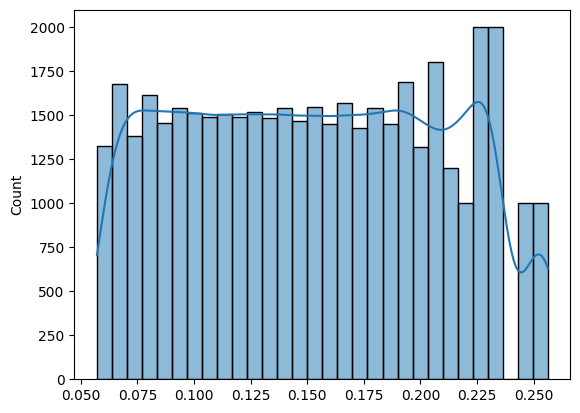

In [55]:
sns.histplot(np.array(all_data['mean_rmse'])[undersample_indeces],bins=30,kde=True)
plt.show()

In [29]:
import numpy as np
a = np.arange(5)
hist, bin_edges = np.histogram(a, density=True)
hist
hist.sum()
np.sum(hist * np.diff(bin_edges))

1.0

In [33]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming value_series is defined as follows.
# Replace this with your actual data if needed.
value_series = pd.Series(np.random.normal(loc=0, scale=1, size=1000))


# --- Transformations and Visualization ---
             
# Apply undersampling
undersampled_data = undersample_to_uniform(value_series, min_count=1000, num_bins=20)

sns.histplot(value_series, bins=30)
plt.show()

# 1. Histogram of original data
sns.histplot(undersampled_data, bins=30)
plt.show()

NameError: name 'values' is not defined

In [9]:
value_series = pd.Series().values()

TypeError: 'numpy.ndarray' object is not callable

In [96]:
size= 60000
values = np.random.normal(loc=0, scale=1, size=size)
indeces = np.arange(size)
data = np.vstack([values,indeces]).T

<Axes: ylabel='Count'>

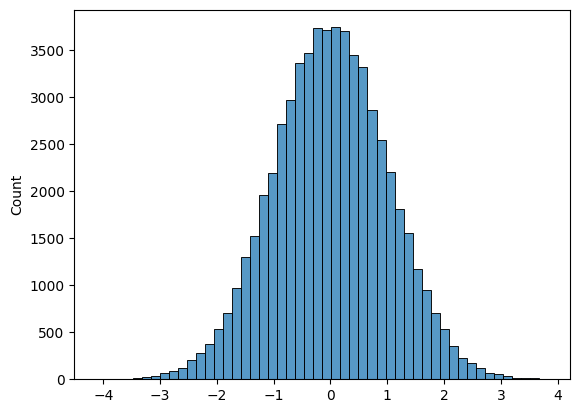

In [97]:
sns.histplot(values,bins=50)

In [116]:
undersampled_indices = undersample_to_uniform(values, min_count= 1000, num_bins=50)


In [51]:
data[50889]

array([-4.20264302e+00,  5.08890000e+04])

<Axes: ylabel='Count'>

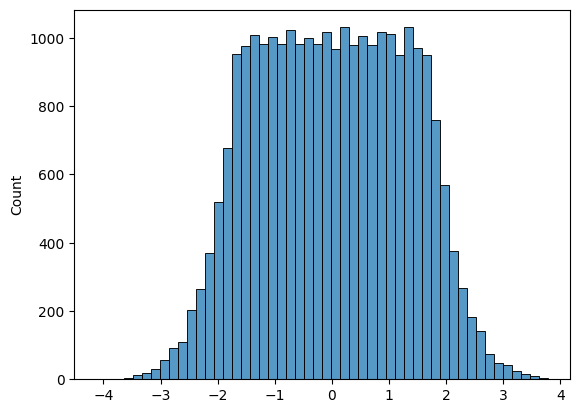

In [118]:
sns.histplot(data[undersampled_indices][:,0],bins = 50)